# 神经网络基础

## 1 人工神经网络：
     是指一系列受生物学和神经科学启发的数学模型。这些模型主要是通过对人脑的神经元网络进行抽象，构建人工神经元，并按照一定拓扑结构来构建人工神经元之间的连接，来模拟生物神经网络。

## 2 神经元
    神经元，是构成神经网络的基本单元，其主要是模拟生物神经元的结构和特性，接收一组输入信号并产生输出。

### 2.1 神经元模型：
   假设一个神经元接收$D$个输入 $x_1, x_2, ..., x_D$, 令向量 $X$（等于前面那个）, 来表示这组输入，并用净输入$ z∈R $表示一个神经元所获得的输入信号x的加权和。

$$ z=\sum^D_{d=1}{w_dx_d + b} $$
$$ = w^Tx+b $$

$ 其中w=[w_1; w_2; ... w_D ] 是D维的权重向量$

### 2.2 激活函数

$$ a = f(z) $$

# 思考题

## 1. 面试题：给定神经网络结构，计算总参数量

### Input X：（$ M×N $） ，Output Y：（$ M，$） 

### 线性层1（$ W_{N×N_1} $） ——> 激活层（？） ——> 线性层2（$ W_{N_1×N} $） ——> 损失（?） 

Parameters: $ M * N_1 $ + $ N_1 * N $    

## 2. 面试题：线性神经网络为什么会出现梯度消失现象？
### Hint：结合反向传播的链式法则来思考

Ans:

    一些激活函数的导函数值在[0,1]间，所以如果连续使用此类激活函数的话，反向传播的时候会乘很多小于1的数值项，因此导致梯度无法很好传播

# 编程题：基于Numpy手工搭建神经网络 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

##  1. 神经网络模块

### 1.1 BaseNode

In [2]:
class BaseNode(object):
    def __init__(self, *args, **kwargs):
        super(BaseNode, self).__init__()
        self.params = {}
        self.grads = {}
        self.results = {}
        self.name = None
        self.inputs = []
        self.outputs = []
        self.is_trainable = True
        for input_ in self.inputs:
            input_.outputs.append(self)
        
    def forward(self):
        raise NotImplementedError
    def backward(self):
        raise NotImplementedError
    def __repr__(self):
        return self.name

### 1.2 LinearNode 

In [69]:
class Linear(BaseNode):
    def __init__(self, input_dim, output_dim, name, bias=True):
        super(Linear, self).__init__()
        self.name = name
        self.bias = bias
        self.W = np.random.randn(input_dim, output_dim) / np.sqrt(input_dim)
        self.params['w'] = self.W
        if bias:
            self.b = np.zeros([1, output_dim])
            self.params['b'] = self.b
    
    def forward(self, x):
        # check type
        assert isinstance(x, np.ndarray)
        # x: batch_size, input_dim
        batch_size = x.shape[0]
        #print("linear batch_size", batch_size)
        y = np.dot(x, self.params['w'])
        #print("linear y_hat: ", y.shape)
        if self.bias and batch_size > 1:
            y += np.tile(self.params['b'], (batch_size ,1))
        self.results['x'] = x
        self.results['y'] = y
        return y
    
    def backward(self, pre_grad):
        # check type
        assert isinstance(pre_grad, np.ndarray)
        # gradient of this layer
        x = self.results['x']
        batch_size, input_dim, output_dim = x.shape[0], x.shape[1], pre_grad.shape[1]
        # gradient of w and b in current layer 
        #print("x: {}, pre_grad: {}".format(x.shape, pre_grad.shape))
        self.grads['w'] = np.dot(x.T, pre_grad) # input_dim, output_dim
        if self.bias: self.grads['b'] = np.sum(pre_grad, axis=0, keepdims=False)# output_dim
        # grad: batch_size, output_dim
        grad_to_input = np.dot(pre_grad, self.W.T)
        return grad_to_input

### 1.3 ActivatedNode 

#### 1.3.1 Sigmoid 

In [4]:
class Sigmoid(BaseNode):
    def __init__(self):
        super(Sigmoid, self).__init__()
        
    def forward(self, x):
        # x: batch_size, output_dim
        sigmoid_value = 1 / (1 + np.exp(-1 * x))
        self.results['sigmoid'] = sigmoid_value
        return sigmoid_value
    
    def backward(self, pre_grad):
        sigmoid_value = self.results['sigmoid']
        grad_input = pre_grad * sigmoid_value * (1 - sigmoid_value)
        return grad_input

#### 1.3.2 Tanh 

In [5]:
class Tanh(BaseNode):
    def __init__(self):
        super(Tanh, self).__init__()
        
    def forward(self, x):
        # x: batch_size, output_dim
        evalue = np.exp(x)
        e_neg_value = np.exp(-1 * x)
        tanh_value = (evalue - e_neg_value) / (evalue + e_neg_value)
        self.results['tanh'] = tanh_value
        return tanh_value
    
    def backward(self, pre_grad):
        tanh_value = self.results['Tanh']
        grad_input = pre_grad * (1 - tanh_value ** 2)
        return grad_input

#### 1.3.3 ReLU

In [6]:
class ReLU(BaseNode):
    def __init__(self):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        # x: batch_size, output_dim
        mask = (x > 0).astype(float)
        relu_value = mask * x
        self.results['relu'] = mask
        return relu_value
    
    def backward(self, pre_grad):
        grad_input = pre_grad * self.results['relu']
        return grad_input

#### 1.3.4 Softmax

In [7]:
class Softmax(BaseNode):
    def __init__(self):
        super(Softmax, self).__init__()
        
    def forward(self, x):
        # x: batch_size, output_dim
        sum_of_x = np.sum(np.exp(x), axis=1) # batch_size
        softmax_value = x / sum_of_x
        self.results['softmax'] = softmax_value
        return softmax_value
    
    def backward(self, pre_grad):
        softmax_value = self.results['softmax']
        grad_input = grad * softmax_value
        return grad_input

### 1.4 LossNode 

#### 1.4.1 L2Loss

In [8]:
class L2Loss(BaseNode):
    def __init__(self):
        super(L2Loss, self).__init__()
    
    def forward(self, x, ground_truth):
        # x: batch_size, dim
        diff = x - ground_truth
        self.results['diff'] = diff
        return np.sum(diff ** 2)
    
    def backward(self):
        grad_input = 2 * self.results['diff']
        return grad_input

#### 1.4.2 Binary Cross Entropy Loss

In [9]:
class BinaryCrossEntropyLoss(BaseNode):
    def __init__(self):
        super(BinaryCrossEntropyLoss, self).__init__()
    
    def forward(self, x, label):
        # x: batch_size, dim
        batch_size = x.shape[0]
        blabel = label.reshape([batch_size, 1])
        bce = -(blabel * np.log(x) + (1 - blabel) * log(1 - x))
        self.results['blabel'] = blabel
        self.results['x'] = x
        return np.sum(bce)
    
    def backward(self):
        grad_input = self.results['blabel']
        x = self.results['x']
        grad_input = -(blabel / x - (1 - blabel) / (1 - x))
        return grad_input

#### 1.4.3 Cross Entropy

In [10]:
class CrossEntropy(BaseNode):
    def __init__(self):
        super(CrossEntropy, self).__init__()
    
    def forward(self, x, ground_truth):
        # x: batch_size, dim
        mask = (x * ground_truth) > 0
        res = x * mask
        self.results['x'] = x
        self.results['crossentropy'] = mask
        return np.sum(res, 1)
    
    def backward(self):
        batch_size = self.results['x'].shape[0]
        grad_input = np.zeros([batch_size, 1])
        for i, x in enumerate(self.results['crossentropy']):
            if x: grad_input[i] = self.results['x'][i] - 1
            else: grad_input[i] = self.results['x'][i]
        return grad_input

### 1.4.4 数据导入

In [11]:
from sklearn.datasets import load_boston

In [12]:
X = load_boston()['data']
y_ = load_boston()['target']

In [13]:
X.shape

(506, 13)

In [67]:
class BostonData(BaseNode):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BostonData, self).__init__()
        self.linear1 = Linear(input_dim, hidden_dim, name='linear1')
        self.relu = ReLU()
        self.linear2 = Linear(hidden_dim, output_dim, 'linear2')
        #self.sigmoid = Sigmoid()
        
    def forward(self, x):
        x = self.linear1.forward(x)
        #print('1', x.shape)
        x = self.relu.forward(x)
        #print('2', x.shape)
        x = self.linear2.forward(x)
        #print('3', x.shape)
        return x
        
    def backward(self, loss):
        grad = self.linear2.backward(loss)
        grad = self.relu.backward(grad)
        grad = self.linear1.backward(grad)
    
    def update(self, learning_rate):
#         print(type(self.linear2.grads))
        self.linear2.params['w'] += (-1) * learning_rate * self.linear2.grads['w']
        if self.linear2.bias: self.linear2.params['b'] += (-1) * learning_rate
        self.linear1.params['w'] += (-1) * learning_rate * self.linear1.grads['w']
        if self.linear2.bias: self.linear1.params['b'] += (-1) * learning_rate

In [15]:
input_dim = 13
hidden_dim = 20
output_dim = 1

In [16]:
from tqdm import tqdm_notebook

In [70]:
model = BostonData(input_dim, hidden_dim, output_dim)
criterion = L2Loss()

learning_rate = 0.00001
epoch = 4000
batch_size = 128
losses = []
min_loss = np.float('inf')

for e in tqdm_notebook(range(epoch)):
    loss = 0
    
    for b in range(batch_size):
        index = np.random.choice(range(len(X)))
        input_vetor = X[index].reshape(1, input_dim)
#         print(input_vetor.shape) 
        y_hat = model.forward(input_vetor)
        output_vector = y_[index].reshape(1, output_dim)
#         print("y_hat shape: {}, y_ shape: {}".format(y_hat.shape, output_vector.shape))
        cost = criterion.forward(y_hat, output_vector)
        cost_grad = criterion.backward()
        model.backward(cost_grad)
        model.update(learning_rate)
        
        loss += cost
    ave_loss = loss / batch_size
    if min_loss > ave_loss:
        min_loss = ave_loss
        print("The {}th epoch, loss:{}".format(e, ave_loss))
    losses.append(ave_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


The 0th epoch, loss:2628.9749039869967
The 1th epoch, loss:113.64704979615338
The 2th epoch, loss:108.0415478725296
The 5th epoch, loss:105.3842555900598
The 6th epoch, loss:104.91968928064212
The 8th epoch, loss:82.09414645615095
The 10th epoch, loss:72.73063796861447
The 12th epoch, loss:55.77339101794017
The 67th epoch, loss:51.13098250487756
The 138th epoch, loss:49.06906214268378
The 175th epoch, loss:44.65652351201641
The 289th epoch, loss:41.37621045756401
The 667th epoch, loss:34.16499700366162
The 1927th epoch, loss:29.56364249272107
The 3717th epoch, loss:28.295813330297587
The 3776th epoch, loss:28.0474365451324



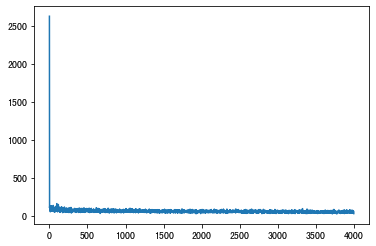

In [71]:
plt.plot(losses)

## 2. dropout机制 

### Ans：

    1. Dropout机制用于丢弃神经网络结点中的一部分，使其不发生作用；
    2. 伪代码：
        parameters is the parameters in the layer
        random_index = random.random(parameters.size())
        for ind in random_index:
          y[ind] = 0

## 3. ELU层 

In [72]:
class ELU(BaseNode):
    def __init__(self):
        super(ELU, self).__init__()
        
    def forward(self, x):
        # x: batch_size, output_dim
        mask = (x > 0).astype(float)
        mask_2 = (x <= 0).astype(float)
        elu_value = mask * x + mask_2 * (np.exp(x) - 1)
        self.results['elu'] = mask + mask_2 * np.exp(x)
        return elu_value
    
    def backward(self, pre_grad):
        grad_input = pre_grad * self.results['elu']
        return grad_input

# 思考题：如何实现自动求导 

### Ans：
    1. 前向传播时，把每个node的输入结点的输出结点设置为自身，所以最后会形成一张计算图；
    2. 在计算图上实现拓扑排序，就可以得到前向传播的方向，逆序便得到反向传播方向。